UEP run but using the negative of the LEP optimized point. As such, this notebook both,
1. Analyzes results
2. Creates starting position

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/11'

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [5]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/na_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [6]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

In [7]:
def f_w(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return np.dot(w, y) - psi_alpha * np.linalg.norm(w) - np.dot(b, c)

def f_w_uep(w, y=y_tilde, psi_alpha=PSI_ALPHA, b=b, c=np.zeros_like(b)):
    """ Lower endpoint functional """
    return -np.dot(w, y) + psi_alpha * np.linalg.norm(w) + np.dot(b, c)

# Plotting Functions

In [8]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization diagnostics

#### Convergence Plots

In [9]:
# read in the raw stdout file
with open(BASE_DIR + '/11/stdout_from_lep08.txt', 'r') as f:
    stdout0_raw = f.readlines()
    
with open(BASE_DIR + '/11/stdout_from_it2.txt', 'r') as f:
    stdout2_raw = f.readlines()
    
with open(BASE_DIR + '/11/stdout_from_it4.txt', 'r') as f:
    stdout4_raw = f.readlines()

In [10]:
# isolate the trajectories from the w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout0_raw if 'At iterate' in line]
all_obj_vals2 = [float(line[22:34].replace('D', 'e')) for line in stdout2_raw if 'At iterate' in line]
all_obj_vals4 = [float(line[22:34].replace('D', 'e')) for line in stdout4_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:4]
traj_c_01 = all_obj_vals[4:7]
traj_w_02 = all_obj_vals[7:8]
traj_c_02 = all_obj_vals[8:]
traj_w_03 = all_obj_vals2[:8]
traj_c_03 = all_obj_vals2[8:11]
traj_w_04 = all_obj_vals2[11:13]
traj_c_04 = all_obj_vals2[13:]
traj_w_05 = all_obj_vals4[:2]
traj_c_05 = all_obj_vals4[2:3]
traj_w_06 = all_obj_vals4[3:5]
traj_c_06 = all_obj_vals4[5:6]
traj_w_07 = all_obj_vals4[6:8]
traj_c_07 = all_obj_vals4[8:9]
traj_w_08 = all_obj_vals4[9:10]
traj_c_08 = all_obj_vals4[10:11]
traj_w_09 = all_obj_vals4[11:13]
traj_c_09 = all_obj_vals4[13:14]
traj_w_09 = all_obj_vals4[11:13]
traj_c_09 = all_obj_vals4[13:14]
traj_w_10 = all_obj_vals4[14:15]
traj_c_10 = all_obj_vals4[15:]

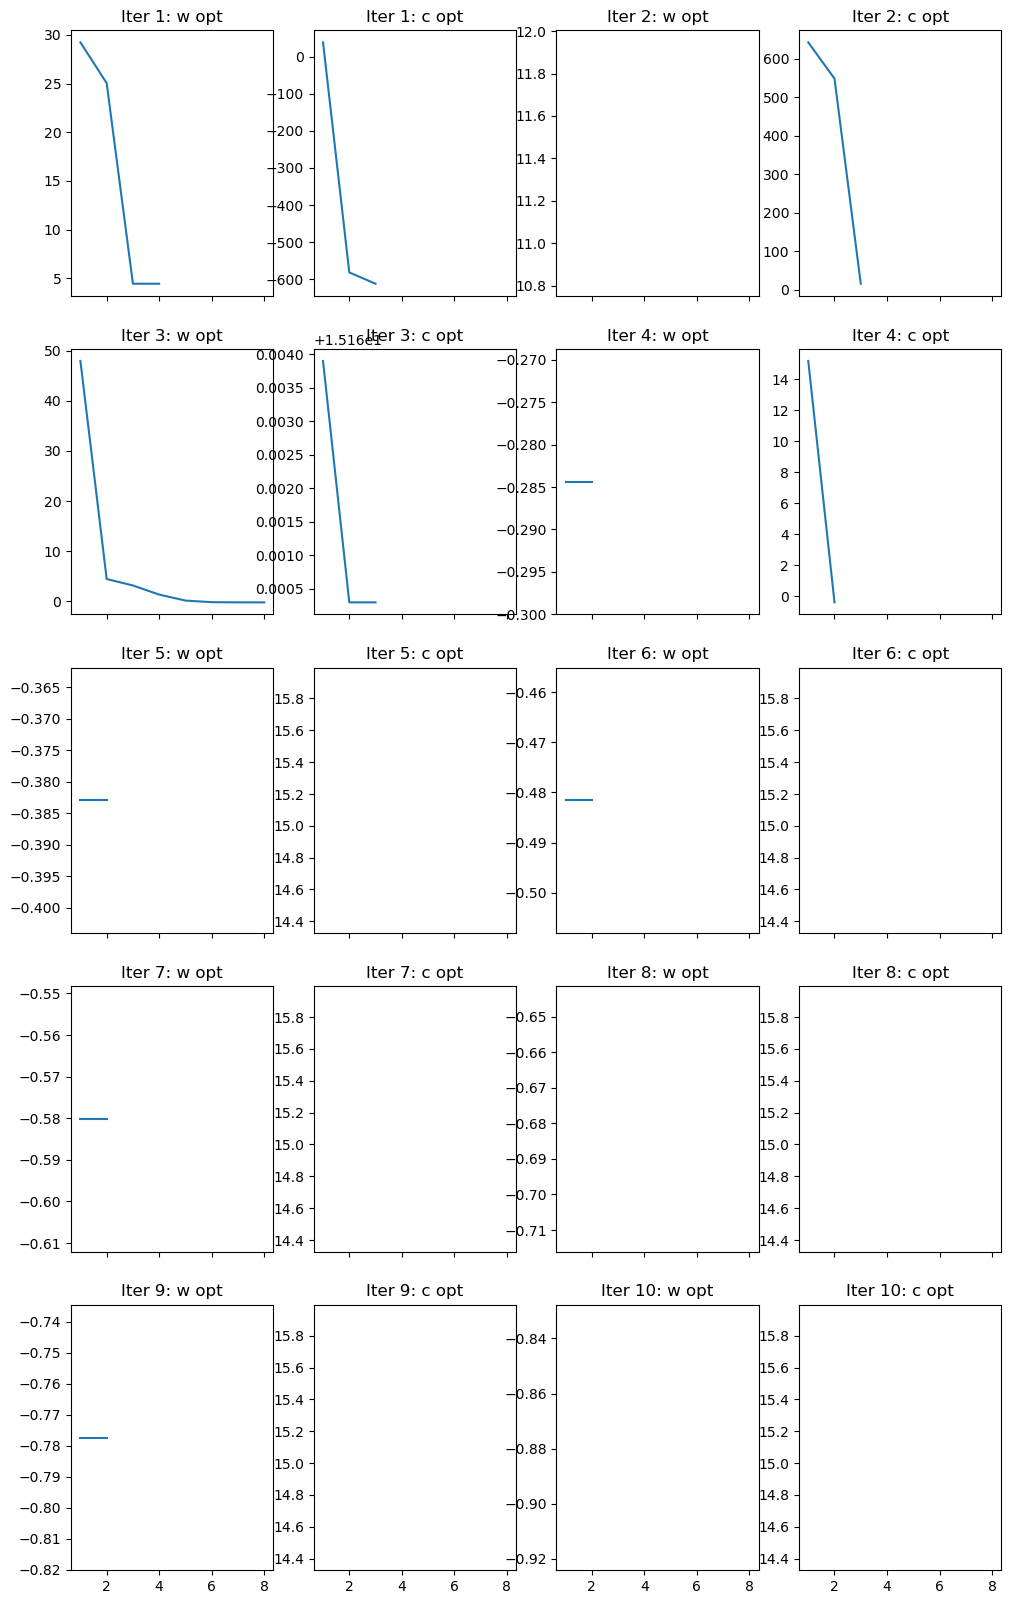

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(12, 20), sharex=True)

# iteration 1
ax[0, 0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
ax[0, 1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)

# iteration 2
ax[0, 2].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
ax[0, 3].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)

# iteration 3
ax[1, 0].plot(np.arange(1, len(traj_w_03) + 1), traj_w_03)
ax[1, 1].plot(np.arange(1, len(traj_c_03) + 1), traj_c_03)

# iteration 4
ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# iteration 5
ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
ax[2, 1].plot(np.arange(1, len(traj_c_05) + 1), traj_c_05)

# iteration 6
ax[2, 2].plot(np.arange(1, len(traj_w_06) + 1), traj_w_06)
ax[2, 3].plot(np.arange(1, len(traj_c_06) + 1), traj_c_06)

# iteration 7
ax[3, 0].plot(np.arange(1, len(traj_w_07) + 1), traj_w_07)
ax[3, 1].plot(np.arange(1, len(traj_c_07) + 1), traj_c_07)

# iteration 8
ax[3, 2].plot(np.arange(1, len(traj_w_08) + 1), traj_w_08)
ax[3, 3].plot(np.arange(1, len(traj_c_08) + 1), traj_c_08)

# iteration 9
ax[4, 0].plot(np.arange(1, len(traj_w_09) + 1), traj_w_09)
ax[4, 1].plot(np.arange(1, len(traj_c_09) + 1), traj_c_09)

# iteration 10
ax[4, 2].plot(np.arange(1, len(traj_w_10) + 1), traj_w_10)
ax[4, 3].plot(np.arange(1, len(traj_c_10) + 1), traj_c_10)

# labels
ax[0, 0].set_title('Iter 1: w opt')
ax[0, 1].set_title('Iter 1: c opt')
ax[0, 2].set_title('Iter 2: w opt')
ax[0, 3].set_title('Iter 2: c opt')
ax[1, 0].set_title('Iter 3: w opt')
ax[1, 1].set_title('Iter 3: c opt')
ax[1, 2].set_title('Iter 4: w opt')
ax[1, 3].set_title('Iter 4: c opt')
ax[2, 0].set_title('Iter 5: w opt')
ax[2, 1].set_title('Iter 5: c opt')
ax[2, 2].set_title('Iter 6: w opt')
ax[2, 3].set_title('Iter 6: c opt')
ax[3, 0].set_title('Iter 7: w opt')
ax[3, 1].set_title('Iter 7: c opt')
ax[3, 2].set_title('Iter 8: w opt')
ax[3, 3].set_title('Iter 8: c opt')
ax[4, 0].set_title('Iter 9: w opt')
ax[4, 1].set_title('Iter 9: c opt')
ax[4, 2].set_title('Iter 10: w opt')
ax[4, 3].set_title('Iter 10: c opt')

plt.show()

#### Final Results

In [12]:
# create endpoint values array
NUM_ITERS = 10
endpoint_vals = np.zeros(NUM_ITERS)

# create feasibility array
feasibility_vals = np.zeros(NUM_ITERS)

In [13]:
# iterations 0-2
with open(BASE_DIR + '/11/final_results_00_01.pkl', 'rb') as f:
    final_res0 = pickle.load(f)
endpoint_vals[:2] = final_res0['objective_evals']

# iterations 2-4
with open(BASE_DIR + '/11/final_results_00_01.pkl', 'rb') as f:
    final_res1 = pickle.load(f)
endpoint_vals[2:4] = final_res1['objective_evals']

# iterations 4-10
with open(BASE_DIR + '/11/final_results_from_it4.pkl', 'rb') as f:
    final_res = pickle.load(f)
endpoint_vals[4:] = final_res['objective_evals']
print(final_res)

{'objective_evals': [0.010997313728726187, 0.01099731372691866, 0.010997313726642104, 0.010997313726642104, 0.010997313726629753, 0.010997313726629753], 'w_opt_output': {'vectors': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.48814630e-07,  3.75550780e-07, -2.30051068e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.48814630e-07,  3.75550780e-07, -2.30051068e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.48814630e-07,  3.75550780e-07, -2.30051068e-05]]), 'status': array([0., 0., 0., 0., 1., 1., 1., 0., 1., 0.]), 'n

In [14]:
# get feasibility values iterations
feasibility_11 = np.zeros(NUM_ITERS)
for i in range(2):
    feasibility_11[i] = np.linalg.norm(h - A.T @ final_res0['c_opt_output']['vectors'][i] - final_res0['KTw_vecs'][i])
    feasibility_vals[i] = feasibility_11[i]
    
for i in range(2):
    feasibility_11[i + 2] = np.linalg.norm(h - A.T @ final_res1['c_opt_output']['vectors'][i] - final_res1['KTw_vecs'][i])
    feasibility_vals[i + 2] = feasibility_11[i + 2]

for i in range(4, NUM_ITERS):
    feasibility_11[i] = np.linalg.norm(h - A.T @ final_res['c_opt_output']['vectors'][i] - final_res['KTw_vecs'][i])
    feasibility_vals[i] = feasibility_11[i]
    
print(feasibility_11)

[1.1382458  0.1996321  1.1382458  0.1996321  0.17355622 0.17355622
 0.17355622 0.17355622 0.17355622 0.17355622]


In [15]:
# fill in holes
with open(BASE_DIR + '/11/res_text2.pkl', 'rb') as f:
    res_stat_02 = pickle.load(f)

with open(BASE_DIR + '/11/res_text3.pkl', 'rb') as f:
    res_stat_03 = pickle.load(f)
    
with open(BASE_DIR + '/11/opt_output_03.pkl', 'rb') as f:
    res_opt_03 = pickle.load(f)

print('-- Opt 3 --')
print(res_stat_03)
print('-- Opt 4 --')
print(res_stat_03)

for i in range(2, 4):
    endpoint_vals[i] = res_opt_03['objective_evals'][i - 2]
    feasibility_vals[i] = np.linalg.norm(h - A.T @ res_opt_03['c_opt_vecs'][i] - res_opt_03['KTw_vecs'][i])

/var/folders/b7/d8ffzgcd7_9_yv2kky00c1y40000gn/T/ipykernel_82630/3278947349.py:3: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  res_stat_02 = pickle.load(f)
/var/folders/b7/d8ffzgcd7_9_yv2kky00c1y40000gn/T/ipykernel_82630/3278947349.py:3: DeprecationWarning: Please use `LbfgsInvHessProduct` from the `scipy.optimize` namespace, the `scipy.optimize.lbfgsb` namespace is deprecated.
  res_stat_02 = pickle.load(f)
/var/folders/b7/d8ffzgcd7_9_yv2kky00c1y40000gn/T/ipykernel_82630/3278947349.py:6: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  res_stat_03 = pickle.load(f)
/var/folders/b7/d8ffzgcd7_9_yv2kky00c1y40000gn/T/ipykernel_82630/3278947349.py:6: DeprecationWarning: Please use `LbfgsInvHessProduct` from the `scipy.optimize` namespace, the `scipy.optimize.lbfgsb` namespace is deprecated.
  res_stat_03

-- Opt 3 --
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  success: True
   status: 0
      fun: -0.2843644085757154
        x: [ 0.000e+00  0.000e+00 ...  3.756e-07 -2.301e-05]
      nit: 1
      jac: [-2.394e-01  1.771e+00 ...  9.216e-02  1.754e-02]
     nfev: 16
 hess_inv: <28267x28267 LbfgsInvHessProduct with dtype=float64>
-- Opt 4 --
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  success: True
   status: 0
      fun: -0.2843644085757154
        x: [ 0.000e+00  0.000e+00 ...  3.756e-07 -2.301e-05]
      nit: 1
      jac: [-2.394e-01  1.771e+00 ...  9.216e-02  1.754e-02]
     nfev: 16
 hess_inv: <28267x28267 LbfgsInvHessProduct with dtype=float64>


In [16]:
endpoint_vals

array([-6.25468706e+02,  1.30084289e-01,  1.09973137e-02,  1.09973137e-02,
        1.09973137e-02,  1.09973137e-02,  1.09973137e-02,  1.09973137e-02,
        1.09973137e-02,  1.09973137e-02])

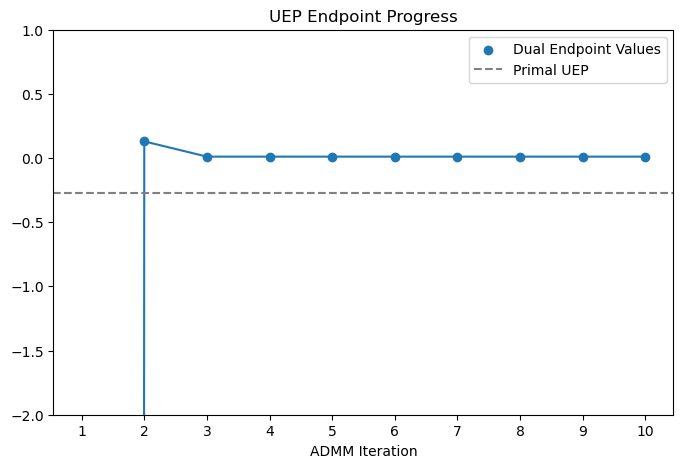

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, NUM_ITERS + 1), endpoint_vals)
plt.scatter(np.arange(1, NUM_ITERS + 1), endpoint_vals, label='Dual Endpoint Values')
plt.axhline(-0.274, linestyle='--', color='gray', label='Primal UEP')
plt.title('UEP Endpoint Progress')
plt.legend()
plt.ylim(-2, 1)
plt.xticks(np.arange(1, NUM_ITERS + 1), labels=np.arange(1, NUM_ITERS + 1))
plt.xlabel('ADMM Iteration')
plt.show()

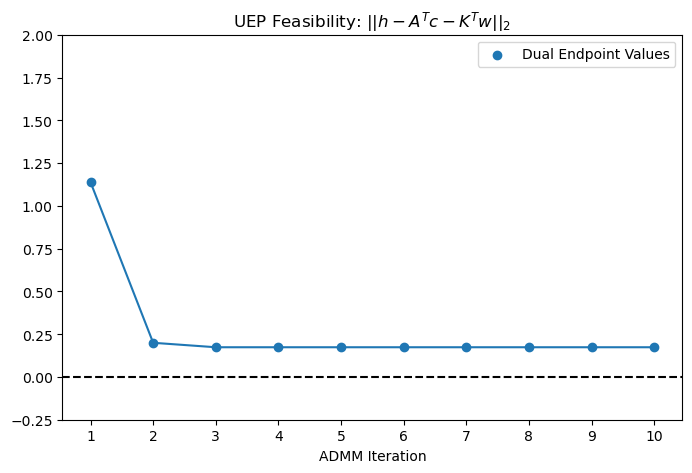

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, NUM_ITERS + 1), feasibility_vals)
plt.scatter(np.arange(1, NUM_ITERS + 1), feasibility_vals, label='Dual Endpoint Values')
plt.axhline(0, linestyle='--', color='black')
plt.title(r'UEP Feasibility: $|| h - A^T c - K^T w ||_2$')
plt.legend()
plt.ylim(-0.25, 2)
plt.xticks(np.arange(1, NUM_ITERS + 1), labels=np.arange(1, NUM_ITERS + 1))
plt.xlabel('ADMM Iteration')
plt.show()

In [17]:
feasibility_vals

array([1.1382458 , 0.1996321 , 0.17355622, 0.17355622, 0.17355622,
       0.17355622, 0.17355622, 0.17355622, 0.17355622, 0.17355622])

# Weights plots

In [32]:
# read in the starting w used
with open('./data/carbon_flux/results/11/intermediate_starts/w_start_from_it2.npy', 'rb') as f:
    w_start = np.load(file=f)

In [34]:
# add columns to the gosat dataframe
gosat_df['w_start'] = w_start

LAST_IDX = 10
for i in range(2, 4):
    
    # weights
    gosat_df[f'w_admm{i}'] = res_opt_03['w_opt_vecs'][i]
    
    # w y prods
    gosat_df[f'w_y_prods{i}'] = gosat_df[f'w_admm{i}'] * y_tilde
    
for i in range(4, LAST_IDX):
    
    # weights
    gosat_df[f'w_admm{i}'] = final_res['w_opt_output']['vectors'][i]
    
    # w y prods
    gosat_df[f'w_y_prods{i}'] = gosat_df[f'w_admm{i}'] * y_tilde

In [35]:
# create a datetime column for the observations
gosat_df['time'] = gosat_df.apply(
    lambda x: pd.to_datetime(f"{int(x['day'])}/{int(x['month'])}/{int(x['year'])}", format="%d/%m/%Y"),
    axis=1
)

# set the above as the index
gosat_df.set_index('time', inplace=True)

#### Global Average Plot

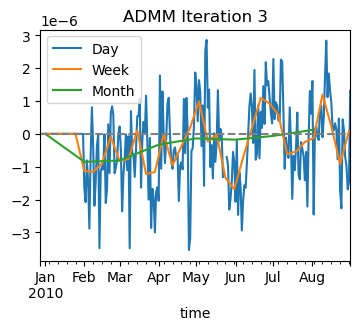

In [23]:
global_avg_plot(w_ser=gosat_df['w_admm2'], title_str=r'ADMM Iteration 3', figsize=(4, 3))

#### Heat Maps

In [36]:
# define a color scheme
norm_start = mcolors.Normalize(
    vmin=gosat_df['w_start'].min(),
    vmax=gosat_df['w_start'].max(),
)
norm = mcolors.Normalize(
    vmin=gosat_df[['w_start', 'w_admm2']].values.flatten().min(),
    vmax=gosat_df[['w_start', 'w_admm2']].values.flatten().max(),
)

In [37]:
# product maps
for i in range(2, LAST_IDX):
    SAVE_FP = SAVE_FIG_BASE + '/w_y_prods%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_y_prods{i}', norm=None, vmin=-0.0005, vmax=0.0005,
        save_fp=SAVE_FP
    )

In [38]:
# after current ADMM iterations
for i in range(2, LAST_IDX):
    SAVE_FP = SAVE_FIG_BASE + '/w_admm%s.png' % str(i).zfill(2)
    month_map_plot(
        df=gosat_df, w_col_str=f'w_admm{i}', norm=None, vmin=-1e-4, vmax=1e-4,
        save_fp=SAVE_FP
    )

In [42]:
# create percent change columns
for i in range(2, LAST_IDX - 1):
    pchg_i = (gosat_df[f'w_admm{i + 1}'] - gosat_df[f'w_admm{i}']) / gosat_df[f'w_admm{i}']
    gosat_df[f'w_pchg_{i}_{i+1}'] = pchg_i.fillna(0)

In [45]:
# heat maps for percent changes
for i in range(2, LAST_IDX - 1):
    SAVE_FP = SAVE_FIG_BASE + '/w_pchg_%s_%s.png' % (str(i).zfill(2), str(i + 1).zfill(2))
    month_map_plot(
        df=gosat_df, w_col_str=f'w_pchg_{i}_{i + 1}', norm=None, vmin=-3.5e-7, vmax=3.5e-7,
        save_fp=SAVE_FP
    )

In [51]:
max_pchg = np.zeros(7)
min_pchg = np.zeros(7)
for i in range(2, LAST_IDX - 1):
    max_pchg[i - 2] = gosat_df[f'w_pchg_{i}_{i + 1}'].describe()['max']
    min_pchg[i - 2] = gosat_df[f'w_pchg_{i}_{i + 1}'].describe()['min']

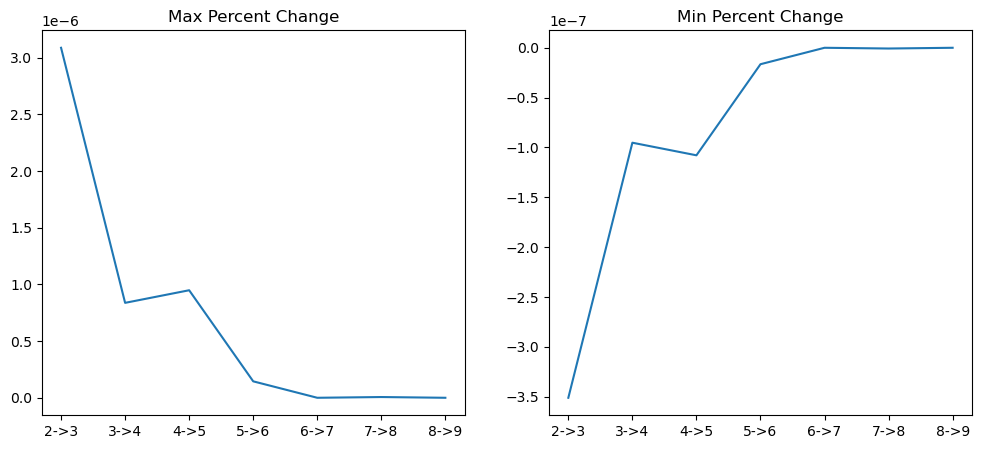

In [61]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
iter_nums = np.arange(2, LAST_IDX - 1)
ax[0].plot(iter_nums, max_pchg)
ax[1].plot(iter_nums, min_pchg)

ax[0].set_title('Max Percent Change')
ax[1].set_title('Min Percent Change')

tick_labels = [f'{i}->{i + 1}' for i in range(2, LAST_IDX - 1)]
for i in range(2):
    ax[i].set_xticks(iter_nums)
    ax[i].set_xticklabels(tick_labels)

plt.show()

# Starting positions

In [10]:
# read in the ending points from LEP 08
with open(BASE_DIR + '/08/final_results.pkl', 'rb') as f:
    final_res_08 = pickle.load(f)

In [14]:
# save the new points to a new iteration 11
SAVE_BASE_SP = './data/carbon_flux/results/11/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_from_neg_lep08.npy', 'wb') as f:
    np.save(file=f, arr=-final_res_08['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_from_neg_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_from_neg_lep08.npy', 'wb') as f:
    np.save(file=f, arr=final_res_08['lambda_opt_output']['vectors'][-1])

#### From first two iterations

In [19]:
# save the new points to a new iteration 11
SAVE_BASE_SP = './data/carbon_flux/results/11/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_from_it2.npy', 'wb') as f:
    np.save(file=f, arr=-final_res['w_opt_output']['vectors'][-1])
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_from_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['c_opt_output']['vectors'][-1])
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_from_it2.npy', 'wb') as f:
    np.save(file=f, arr=final_res['lambda_opt_output']['vectors'][-1])

#### From first four iterations

In [25]:
# optimization output from ADMM iteration 03
with open(BASE_DIR + '/11/opt_output_03.pkl', 'rb') as f:
    res_opt_03 = pickle.load(f)

In [28]:
# save the new points to a new iteration 11
SAVE_BASE_SP = './data/carbon_flux/results/11/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_from_it4.npy', 'wb') as f:
    np.save(file=f, arr=res_opt_03['w_opt_vecs'][3])
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_from_it4.npy', 'wb') as f:
    np.save(file=f, arr=res_opt_03['c_opt_vecs'][3])
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_from_it4.npy', 'wb') as f:
    np.save(file=f, arr=res_opt_03['lambda_opt_vecs'][3])